In [32]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
df = pd.read_csv('flights.jan.csv')

In [3]:
print('Dimensões do dataframe: ', df.shape)

Dimensões do dataframe:  (469968, 32)


# Limpeza

In [15]:
# informações de valores nulos e tipos das colunas

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'tipo de dado'})

tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'valores nulos (contagem)'}))

tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'valores nulos (%)'}))
tab_info

/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_7065/3741533118.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'valores nulos (contagem)'}))
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_7065/3741533118.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'valores nulos (%)'}))


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
tipo de dado,int64,int64,int64,int64,int64,object,int64,object,object,object,...,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
valores nulos (contagem),0,0,0,0,0,0,0,2782,0,0,...,12271,12955,0,0,457986,374017,374017,374017,374017,374017
valores nulos (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591955,0.0,0.0,...,2.611029,2.756571,0.0,0.0,97.450465,79.583504,79.583504,79.583504,79.583504,79.583504


In [3]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [4]:
# Função que converte a string 'HHMM' em datetime.time

def formatar_horario(dado_orig):
  if pd.isnull(dado_orig):
    return np.nan
  else:
    if dado_orig == 2400: dado_orig = 0
    dado_orig = "{0:04d}".format(int(dado_orig))
    horario = datetime.time(int(dado_orig[0:2]), int(dado_orig[2:4]))
    return horario


# Função que combina a data e o horario para criar um datetime.datetime

def combinar_data_horario(x):
  if pd.isnull(x[0]) or pd.isnull(x[1]):
    return np.nan
  else:
    return datetime.datetime.combine(x[0],x[1])


# Função que combina duas colunas do dataframe para criar um formato datetime

def criar_horario_voo(df, col):    
  lista = []
  for index, cols in df[['DATE', col]].iterrows():    
    if pd.isnull(cols[1]):
      lista.append(np.nan)
    elif float(cols[1]) == 2400:
      cols[0] += datetime.timedelta(days=1)
      cols[1] = datetime.time(0,0)
      lista.append(combinar_data_horario(cols))
    else:
      cols[1] = formatar_horario(cols[1])
      lista.append(combinar_data_horario(cols))
  return pd.Series(lista)

In [5]:
df['SCHEDULED_DEPARTURE'] = criar_horario_voo(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(formatar_horario)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(formatar_horario)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(formatar_horario)

In [21]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [6]:
a_remover = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME', 'Unnamed: 0']

df.drop(a_remover, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME']]

df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [7]:
valores_faltantes_df = df.isnull().sum(axis=0).reset_index()
valores_faltantes_df.columns = ['Variável', 'Valores faltantes']
valores_faltantes_df['Valores presentes (%)'] = (df.shape[0]-valores_faltantes_df['Valores faltantes'])/df.shape[0]*100
valores_faltantes_df.sort_values('Valores presentes (%)').reset_index(drop = True)

,Variável,Valores faltantes,Valores presentes (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [8]:
df.dropna(inplace = True)

In [36]:
df.isnull().sum()

AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
SCHEDULED_TIME         0
ELAPSED_TIME           0
dtype: int64

# Comparando companhias aéreas

In [9]:
companhias_aereas = pd.read_csv('airlines.csv')
companhias_aereas

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [10]:
abrev_companhias = companhias_aereas.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [11]:
# Função que extrai parâmetros estatísticos a partir de um objeto groupby:

def get_stats(group):
  return {'min': group.min(), 'max': group.max(), 'contagem': group.count(), 'média': group.mean()}

In [12]:
# Criação de um dataframe com informações estatísticas de cada companhia:

estats_companhias = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
estats_companhias = estats_companhias.sort_values('contagem')
estats_companhias

,min,max,contagem,média
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


## Gráficos

In [13]:
fonte = {'family' : 'verdana', 'weight' : 'bold', 'size' : 15}
mpl.rc('font', **fonte)

In [16]:
# Extrair um subset de colunas e redefinir os nomes das companhias aéreas

df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abrev_companhias)

In [17]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 
          'lightskyblue', 'lightcoral', 'yellowgreen', 'gold', 
          'tomato', 'violet', 'aquamarine', 'chartreuse']

/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/2410671427.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(


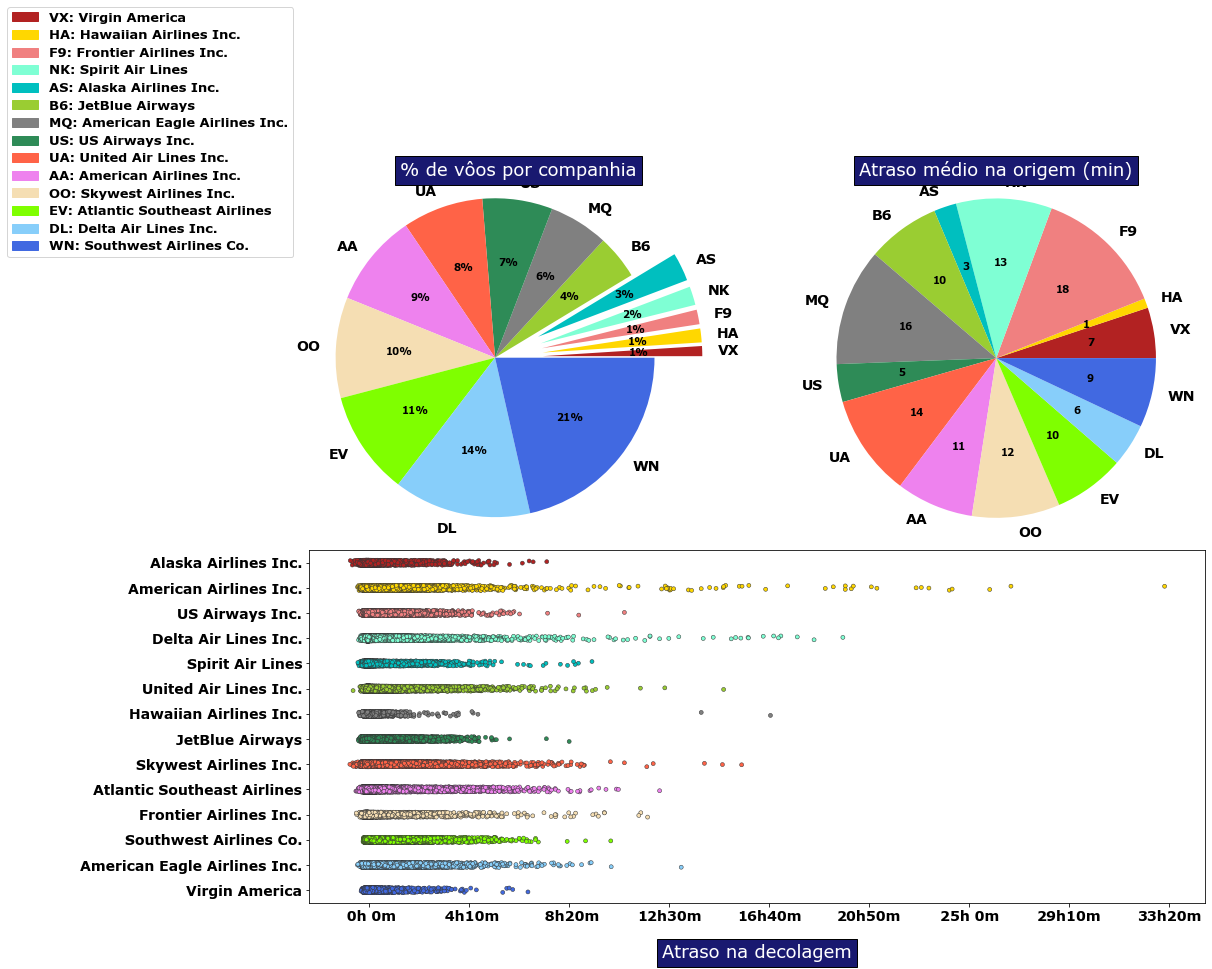

In [25]:
fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# --
# Gráfico de pizza 1: número de vôos

labels = [s for s in estats_companhias.index]
sizes = estats_companhias['contagem'].values
explode = [0.3 if sizes[i] < 20000
           else 0.0 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    autopct='%1.0f%%', shadow=False,
                                    startangle=0)

for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)

ax1.axis('equal')
ax1.set_title('% de vôos por companhia',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Colocando a legenda: abreviação -> nome da companhia aérea

comp_handler = []
for i in range(len(abrev_companhias)):
    comp_handler.append(mpatches.Patch(color=colors[i],
                                       label=estats_companhias.index[i] + ': ' + abrev_companhias[estats_companhias.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9),
           fontsize=13, bbox_transform=plt.gcf().transFigure)

# --
# Gráfico de pizza 2: atraso médio ao decolar

sizes = estats_companhias['média'].values
sizes = [max(s, 0) for s in sizes]
explode = [0.0 if sizes[i] < 20000
           else 0.01 for i in range(len(abrev_companhias))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode,
                                    labels=labels, colors=colors,
                                    shadow=False, startangle=0,
                                    autopct=lambda p: '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abrev_companhias)):
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Atraso médio na origem (min)',
              bbox={'facecolor': 'midnightblue', 'pad': 5},
              color='w', fontsize=18)

# --
# Strip plot com todos os valores reportados para atrasos
# Redefinindo as cores para corresponder com os gráficos de pizza

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c',
          'yellowgreen', 'grey', 'seagreen', 'tomato', 'violet',
          'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

# --

ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size=4,
                    palette=colors, data=df2, linewidth=0.5,
                    jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
    *[int(y) for y in divmod(x, 60)])
    for x in ax3.get_xticks()])
plt.xlabel('Atraso na decolagem', fontsize=18,
           bbox={'facecolor': 'midnightblue', 'pad': 5}, 
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

# --

plt.tight_layout(w_pad=3)

In [26]:
# Função que define como atrasos são agrupados

tipo_atraso = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(tipo_atraso)

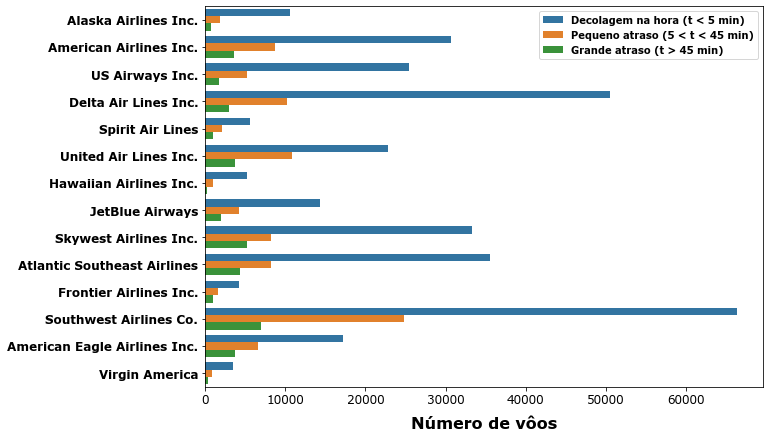

In [28]:
fig = plt.figure(1, figsize=(10, 7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Substituindo as abreviações pelo nome completo das companhias aéreas e colocando os labels

labels = [abrev_companhias[item.get_text()]
          for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight='normal', rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight='bold', rotation=0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Número de vôos', fontsize=16, weight='bold', labelpad=10)


# Colocando a legenda

L = plt.legend()
L.get_texts()[0].set_text('Decolagem na hora (t < 5 min)')
L.get_texts()[1].set_text('Pequeno atraso (5 < t < 45 min)')
L.get_texts()[2].set_text('Grande atraso (t > 45 min)')


plt.show()


In [29]:
# Função modelo usada para fitar os histogramas
def fit_hist(x, a, b):
  return a * np.exp(-x/b)


/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/605126590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticks()])
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/605126590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticks()])
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/605126590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticks()])
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/605126590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for x in ax.get_xticks()])
/var/folders/m6/535gs6dj4pl874nwyz4wq4340000gn/T/ipykernel_6364/605126590.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xti

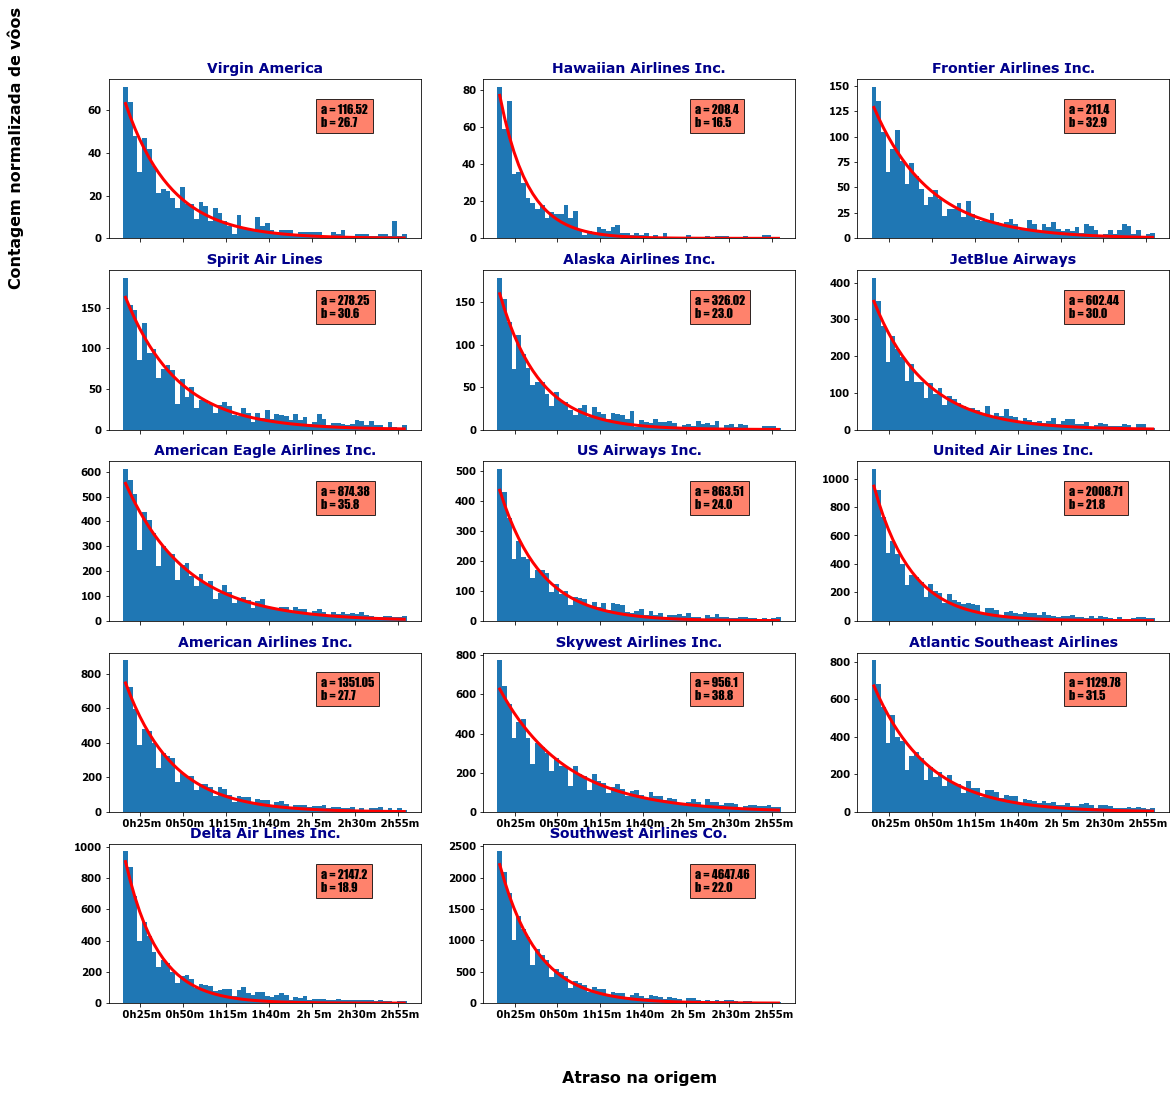

In [53]:
pontos = []
label_comp = []

fig = plt.figure(1, figsize=(19,17))

i = 0
for nome_comp in [abrev_companhias[x] for x in estats_companhias.index]:
    i += 1
    ax = fig.add_subplot(5, 3, i)

    # Fitar a distribuição
    n, bins, patches = plt.hist(x=df2[df2['AIRLINE'] == nome_comp]
                                ['DEPARTURE_DELAY'], range=(15, 180),
                                 bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(fit_hist, bin_centers, n, p0=[1, 2])

    # Contabilizando os resultados
    pontos.append(popt)
    label_comp.append(nome_comp)

    # Desenhando a curva fitada
    plt.plot(bin_centers, fit_hist(bin_centers, *popt), 'r-', linewidth=3)

    # Definindo as marcações em cada subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(
            *[int(y) for y in divmod(x, 60)])
            for x in ax.get_xticks()])

    # Título do subplot
    plt.title(nome_comp, fontsize=14, fontweight='bold', color='darkblue')

    # Labels dos eixos
    if i == 4:
        ax.text(-0.3, 0.9, 'Contagem normalizada de vôos', fontsize=16,
                rotation=90, color='k', horizontalalignment='center',
                transform=ax.transAxes)
    if i == 14:
        ax.text(0.5, -0.5, 'Atraso na origem', fontsize=16, rotation=0,
                color='k', horizontalalignment='center',
                transform=ax.transAxes)

    # Legenda: valores dos coeficientes a e b
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0], 2),
            round(popt[1], 1)), style='italic', transform=ax.transAxes,
            fontsize=12, family='fantasy', bbox={'facecolor': 'tomato',
            'alpha': 0.8, 'pad': 5})

plt.tight_layout()
